# Alternative way to detect license plates using Machine Learning and OCR

Basicly this notebook shows how the Text from license plates is detected and extracted. It is a 2 step process:
1. Find / detect the license plates in an image
2. Get the Text from the license plates

## 1. Finding the license plates in an image

Many many pretrained Machine Learning Modells exist for finding license plates enabling me to skip the work of training (or even creating) a Machine Learning Architecture.    
    

Nonetheless I already have some experience with Machine Learning, CNN (Convoluted Neural Networks) and at least Iamge Classification. 

#### How I spend time on a not working Machine Learning Model
First i thought about following model:      
https://github.com/soonhahwang/Mobilenet-SSD-to-detect-Licence-Plate    
 I do not have a GPU and my CPU is not the best either.     
Therefore I wanted to not use any pretrained model but one which can be even used for embedded devices.

MobileNet is a famous CNN Architecture. It is not as accurate as other CNNs but it is fast and can be used on devices with low computing power. SSD (Single Shot Detector) is a famous Object Detection Algorithm. One of its key features is indeed the use of bounding boxes to identify and locate objects within an image.    
 -> But it ended up not working because there is no requirements.txt and I just could not make the code run. With some trickery I actually ended up making it work but it was not able to detect any license plates so I am not sure what the problem was.
 
### Yolo Model

After this I gave up on focusing on possible realtime detection on my laptop and just wanted to get a working model. Therefore i decided to go with the most popular Object Detection Algorithm: Yolo.
With the website huggingface.com, which offers easy installation and many pretrained models, after a few tries I found an adequate model.  The following code shows a simple example of how to use the model. 

To try please install:
pip install -U yolov5

### 1.1 The results of the Yolo Model

YOLOv5  2023-12-5 Python-3.11.2 torch-2.1.1+cpu CPU

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


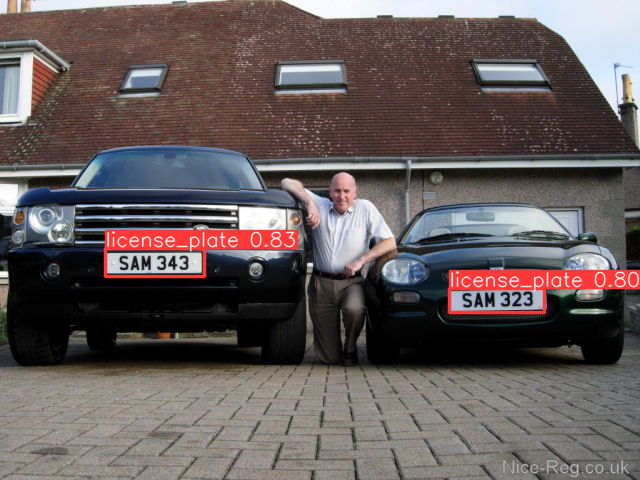

In [45]:
import yolov5

# load model
model = yolov5.load('keremberke/yolov5m-license-plate')

# set model parameters
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image

# set image
img_path = '../data/license_plate_images/eu-1.jpg'

# perform inference
# results = model(img, size=640)

# inference with test time augmentation
results = model(img_path, augment=True)

# parse results
predictions = results.pred[0]
boxes = predictions[:, :4]  # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

# display results in notebook 
results.show()


### 1.2 Extract the license plates from the image

To read the text of each license plate I need to extract the license plates from the image. Afterwards on each of the plates OCR can we used to read the text.   

Do not get them if they are very similiar image parts. Sometimes it puts two bounding boxes on the same license plate. This is not a problem for the OCR but it is for the next step.



In [46]:
import cv2 as cv

img = cv.imread(img_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)


# Get only the license plates
plates = []
for box in boxes:
    x1, y1, x2, y2 = box
    plate = img[int(y1):int(y2), int(x1):int(x2)]
    plates.append(plate)

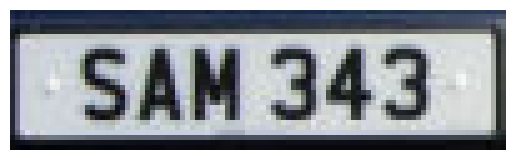

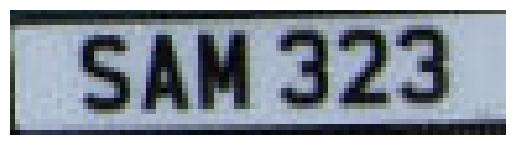

In [47]:
import matplotlib.pyplot as plt

#change backend to show images in notebook
%matplotlib inline
def display_plates(plates):
    for plate in plates:
        plt.imshow(plate)
        plt.axis('off')
        plt.show()
        
display_plates(plates)


## 2. Get the Text from the license plates

Now use OCR (Optical Character Recognition) to read the text from the license plates.    
There are many options for OCR. F.ex. EasyOCR or Tesseract.

### 2.1 Tesseract and EasyOCR

Do not achieve desired results. Even not with preprocessing.

In [48]:
# Tesseract
import pytesseract
#EasyOCR
import easyocr

pytesseract.pytesseract.tesseract_cmd = "C:\\Users\\bensc\\AppData\\Local\\Programs\\Tesseract-OCR\\tesseract.exe"

reader = easyocr.Reader(['en'])

#recognize text on plates images
for plate in plates:
    text = pytesseract.image_to_string(plate, lang='eng')
    print("Tesseract: ",text)
    # EasyOCR
    result = reader.readtext(plate)
    text = result[0][1]
    print("EasyOCR: ", text)
    print("\n\n")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Tesseract:  
EasyOCR:  SAM343


Tesseract:  SAM 323

EasyOCR:  5323


### Can results be improved with preprocessing?

No it does not change anything.

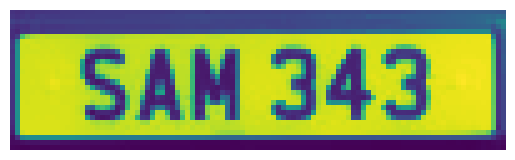

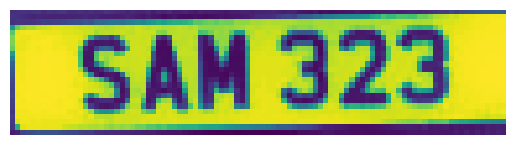

In [49]:
def preprocess(image):
    gray = cv.cvtColor(image.copy(), cv.COLOR_BGR2GRAY)
    gray = cv.bilateralFilter(gray, 11, 17, 17)
    # gray = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    return gray

preprocessed_plates = [preprocess(plate) for plate in plates]
display_plates(preprocessed_plates)

In [50]:
#try ocr again 

for plate in plates:
    text = pytesseract.image_to_string(plate, lang='eng')
    print("Tesseract: ",text)
    # EasyOCR
    result = reader.readtext(plate)
    text = result[0][1]
    print("EasyOCR: ", text)
    print("\n\n")
    

Tesseract:  
EasyOCR:  SAM343


Tesseract:  SAM 323

EasyOCR:  5323


### Keras OCR 

Using keras + tensorflow pretrained Models.
Achieves better results than Tesseract and EasyOCR but requires more computing power.

Looking for C:\Users\bensc\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\bensc\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step


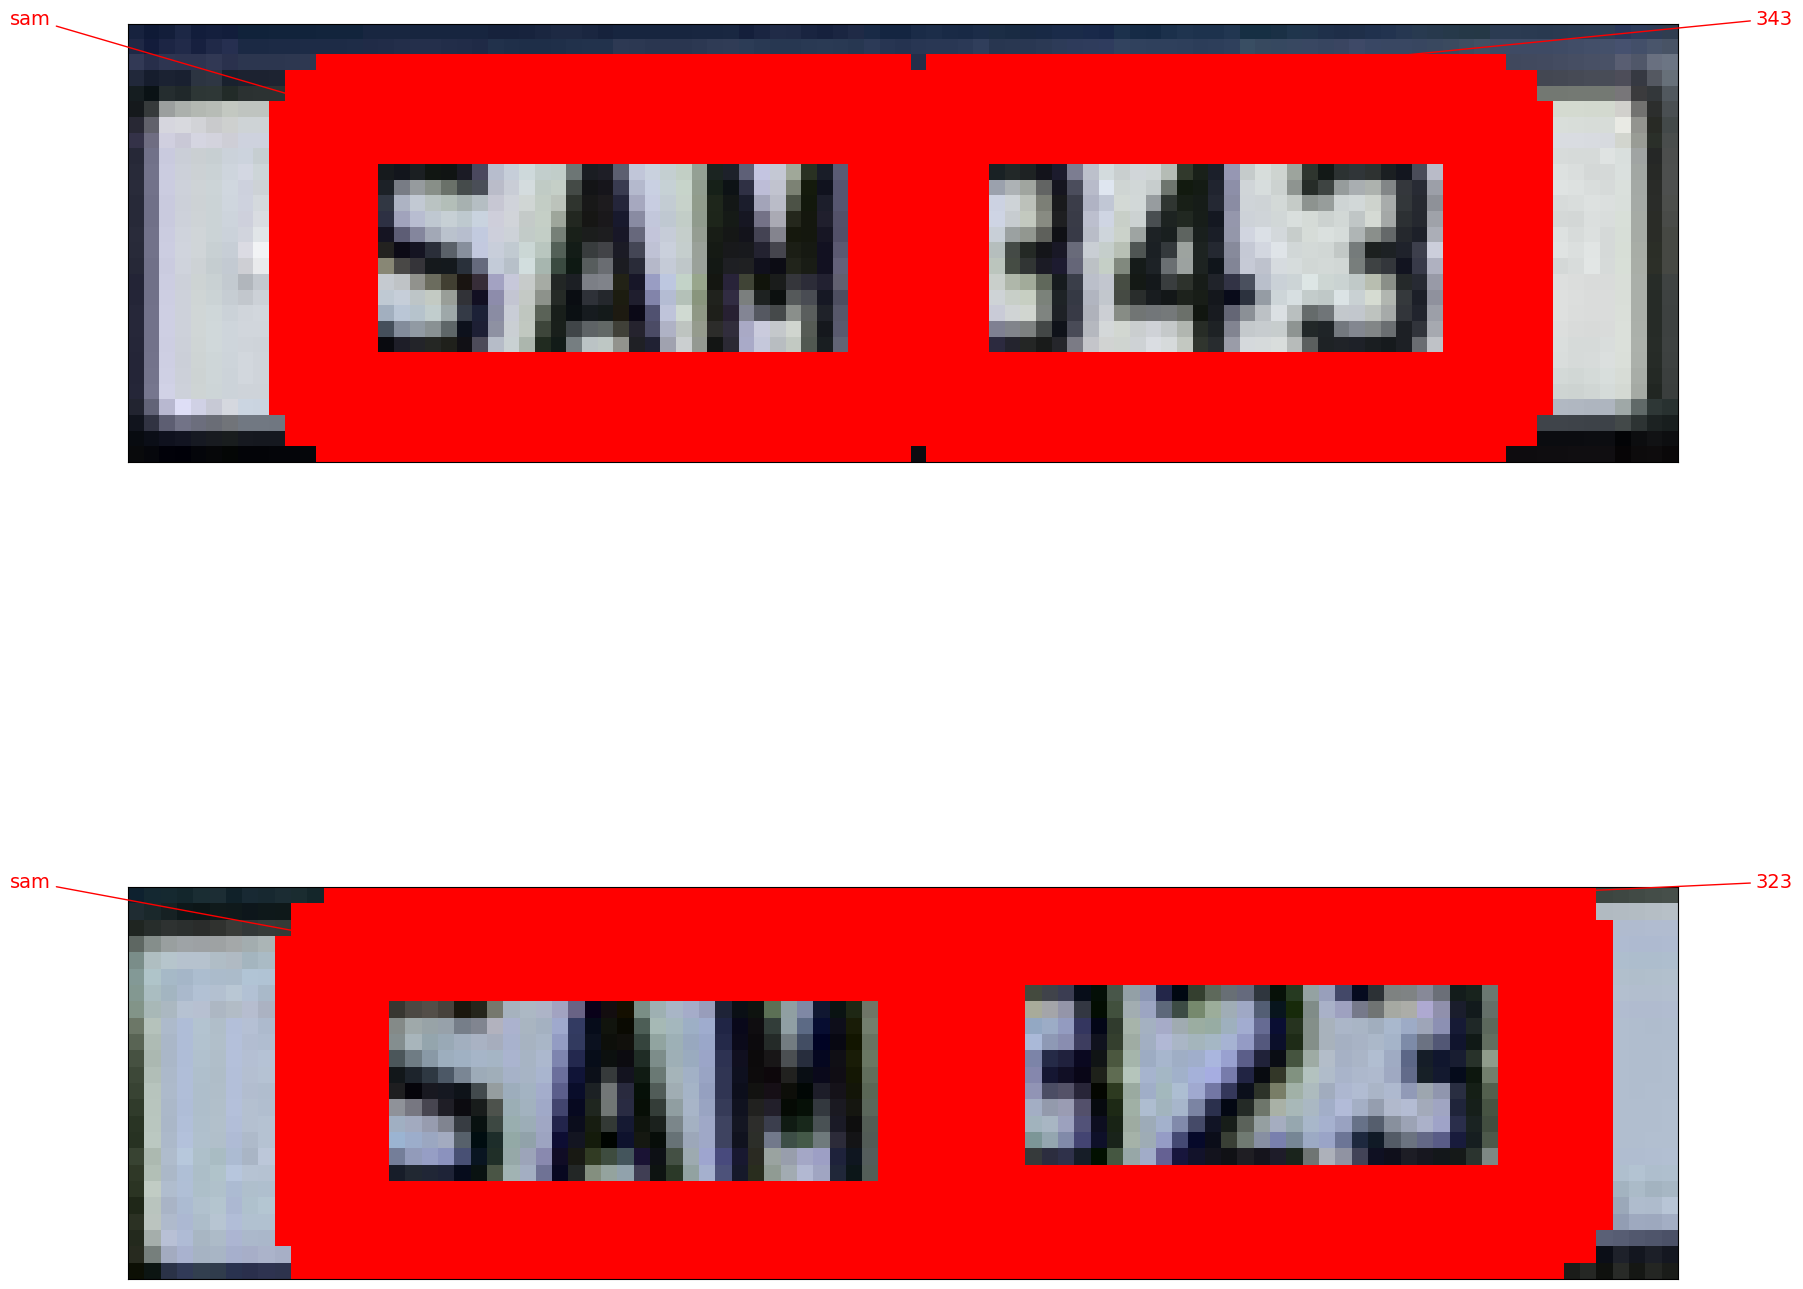

In [55]:
# Try alternative:
# keras-ocr

import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

# use plates 
predictions_from_keras = pipeline.recognize(plates)
# print predictions
fig, axs = plt.subplots(nrows=len(plates), figsize=(20, 20))
for ax, image, predictions in zip(axs, plates, predictions_from_keras):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

In [56]:
# print all recognized text of each image
for i, plate in enumerate(plates):
    print("Plate ", i)
    #damit die predicitions von links nach rechts sortiert sind
    sorted_predictions = sorted(predictions_from_keras[i], key=lambda x: x[1][0][0])
    for prediction in sorted_predictions:
        print(prediction[0])

Plate  0
sam
343
Plate  1
sam
323



## 3. Conclusion und Results with examples using the module written

### Conclusion

The results are not perfect but very good. The model is able to detect the license plates and read the text. It is better than OpenALPR on my example data.   

The biggest downside is the computing power required. It is not possible to use this model in real time on any embedded hardware or without a GPU.      
I think a similiar architecture could easily achieve real time performance on hardware without a high-end GPU (especially with an additional EDGE TPU) if you use very small net. I suggest SSD MobileNet instead of the YOLO which has an inference time of 0.03 seconds on a Google Coral TPU.

### Nutzung

YOLOv5  2023-12-5 Python-3.11.2 torch-2.1.1+cpu CPU

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


Looking for C:\Users\bensc\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\bensc\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 1s 551ms/step


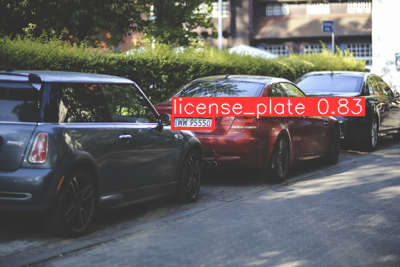

License Plates detected:  ['']
1/1 [==============================] - 1s 596ms/step


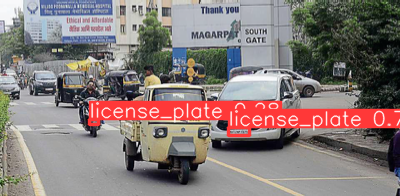

License Plates detected:  ['', '']
1/1 [==============================] - 2s 2s/step
nlgo
lxb


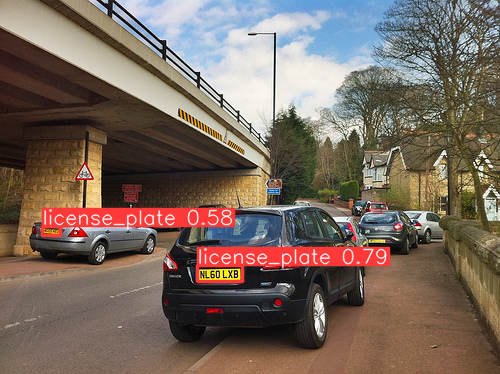

License Plates detected:  ['nlgolxb', '']
1/1 [==============================] - 0s 287ms/step
mat
20
ee
7598


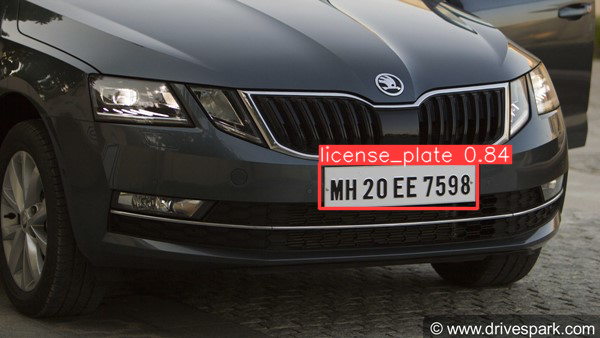

License Plates detected:  ['mat20ee7598']
1/1 [==============================] - 0s 106ms/step


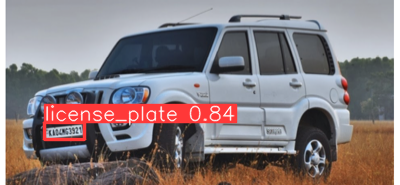

License Plates detected:  ['']
1/1 [==============================] - 0s 108ms/step
zioin


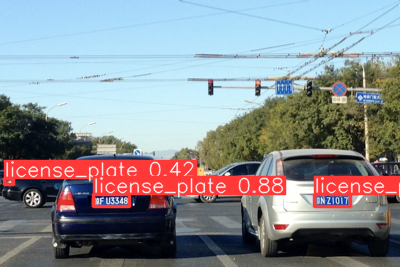

License Plates detected:  ['', 'zioin', '']
1/1 [==============================] - 0s 253ms/step
sam
343
sam
323


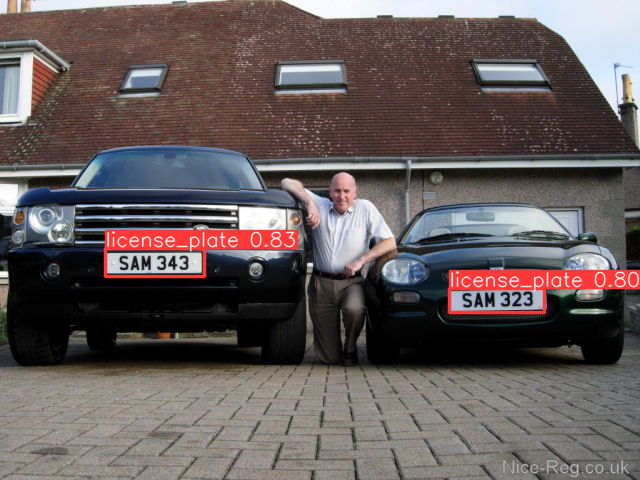

License Plates detected:  ['sam343', 'sam323']
1/1 [==============================] - 0s 164ms/step
he786
poj


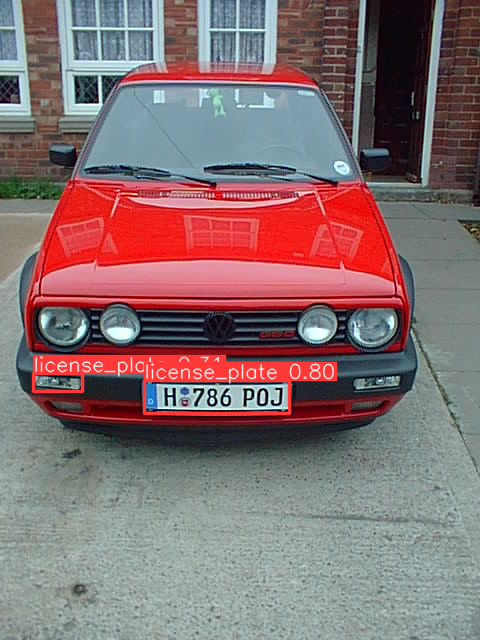

License Plates detected:  ['he786poj', '']
1/1 [==============================] - 0s 122ms/step
thecar


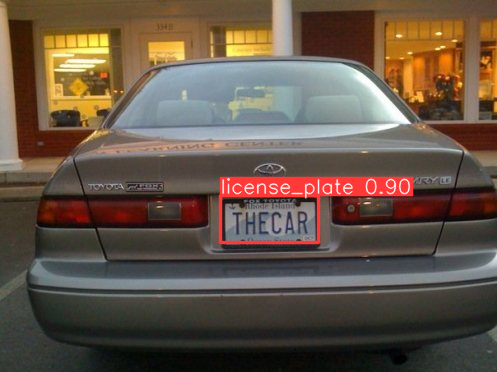

License Plates detected:  ['thecar']
1/1 [==============================] - 0s 111ms/step
yeauxlo


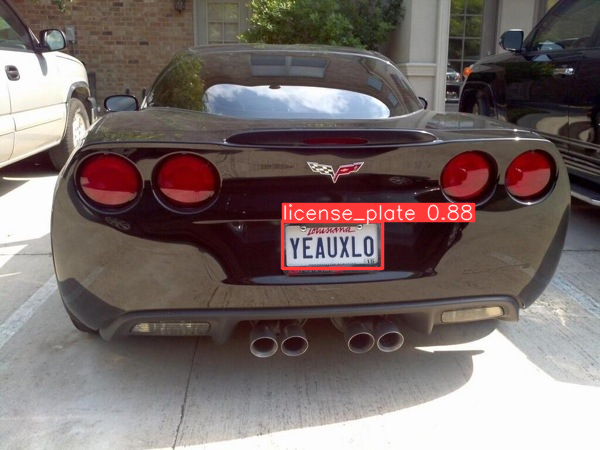

License Plates detected:  ['yeauxlo']


In [4]:
from scan_license_plates import LicensePlateScanner
import os
import matplotlib.pyplot as plt
import cv2 as cv
#adjust matpllotlib backend to show images in notebook
%matplotlib inline

scanner = LicensePlateScanner()

# try all examples in folder "../data/license_plate_images"
for image in os.listdir(r"C:\Users\bensc\Projects\additions_to_conv_lane_detect\data\license_plate_images"):
# for image in [r"eu-1.jpg"]:
#     print(image)
    image_path = os.path.join("../data/license_plate_images", image)
    # print(image_path)
    text, image_result = scanner.get_license_plate_text(image_path)
    print("License Plates detected: ",text)